In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from IPython.display import Markdown, display

# 1. 데이터 확인 과정

In [6]:
# 데이터 경로
base_dir = Path(r'C:\Users\ysm\Desktop\dataset')
brands = ['coca', 'fanta', 'pepsi', 'pocari', 'sprite']  # 브랜드 목록

# 각 브랜드별 이미지 파일 경로 수집
filepaths = []
labels = []

for brand in brands:
    brand_dir = base_dir / brand  # 각 브랜드의 폴더 경로
    brand_images = list(brand_dir.glob(r'*.jpg'))  # JPG 이미지만 수집
    filepaths.extend(brand_images)
    labels.extend([brand] * len(brand_images))  # 브랜드 이름으로 라벨 지정

# 데이터프레임 생성
df = pd.DataFrame({
    'Filepath': [str(fp) for fp in filepaths],
    'Label': labels
})

# 음료수 별 이미지 수 최소값 찾기 
min_count = df['Label'].value_counts().min()

# 그 수를 기준으로 샘플링
can_df = pd.concat([
    df[df['Label'] == brand].sample(min_count, random_state=0)
    for brand in brands
])
can_df = can_df.sample(frac=1, random_state=0).reset_index(drop=True)

# 라벨링 확인
print(can_df)

                                            Filepath   Label
0     C:\Users\ysm\Desktop\dataset\sprite\spri97.jpg  sprite
1      C:\Users\ysm\Desktop\dataset\pepsi\peps87.jpg   pepsi
2      C:\Users\ysm\Desktop\dataset\coca\coca186.jpg    coca
3    C:\Users\ysm\Desktop\dataset\sprite\spri104.jpg  sprite
4       C:\Users\ysm\Desktop\dataset\coca\coca38.jpg    coca
..                                               ...     ...
665    C:\Users\ysm\Desktop\dataset\coca\coca160.jpg    coca
666   C:\Users\ysm\Desktop\dataset\pepsi\peps166.jpg   pepsi
667    C:\Users\ysm\Desktop\dataset\fanta\fant62.jpg   fanta
668   C:\Users\ysm\Desktop\dataset\sprite\spri16.jpg  sprite
669   C:\Users\ysm\Desktop\dataset\sprite\spri81.jpg  sprite

[670 rows x 2 columns]


In [7]:
print(f'Number of pictures: {can_df.shape[0]}\n')
print(f'Number of different labels: {len(can_df.Label.unique())}\n')
print(f'Labels: {can_df.Label.unique()}')

Number of pictures: 670

Number of different labels: 5

Labels: ['sprite' 'pepsi' 'coca' 'fanta' 'pocari']


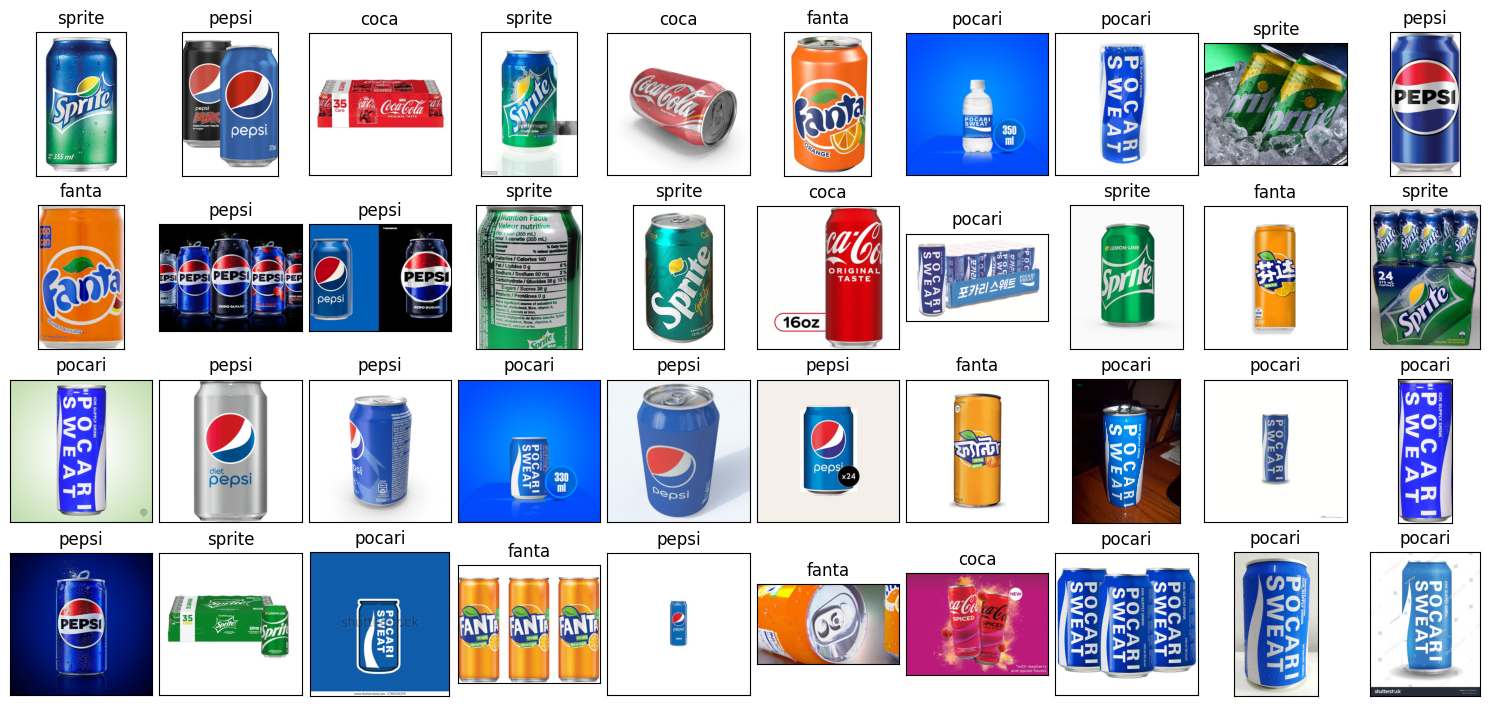

In [8]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(can_df.Filepath[i]))
    ax.set_title(can_df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

C:\Users\ysm\AppData\Local\Temp\ipykernel_22548\1626255598.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


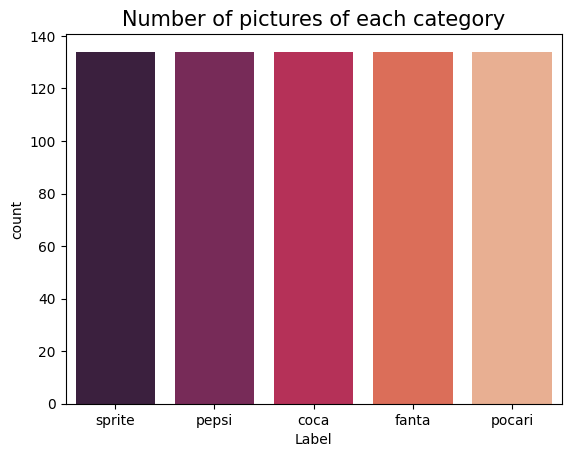

In [9]:
# Label Category 분포 확인
vc = can_df['Label'].value_counts()
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

# 이미지 데이터 분류 Train:Test=9:1

In [10]:
# 이미지 데이터 Train, Test 데이터로 분류
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((684, 2), (77, 2))

# 모델 생성

In [11]:
# 라벨링 및 전처리
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory(r'C:\Users\ysm\Desktop\dataset',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory(r'C:\Users\ysm\Desktop\dataset',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 610 images belonging to 5 classes.
Found 151 images belonging to 5 classes.


**데이터 증강(Data Augmentation)으로 이미지 로드**

In [12]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [10]:
import tensorflow as tf
from kerastuner.tuners import RandomSearch

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# 모델 구성 및 하이퍼파라미터 설정을 위한 함수
def tuning_model(hp):
    model = tf.keras.models.Sequential()
    
    # 첫 번째 합성곱 레이어
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),  # 필터 수 설정
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),  # 커널 크기 선택
        activation=hp.Choice('conv_1_activation', values=['relu', 'elu']),  # 활성화 함수 선택
        input_shape=(224, 224, 3)
    ))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    
    # 두 번째 합성곱 레이어
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),  # 필터 수 설정
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),  # 커널 크기 선택
        activation=hp.Choice('conv_2_activation', values=['relu', 'elu'])  # 활성화 함수 선택
    ))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    # 세 번째 합성곱 레이어
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),  # 필터 수 설정
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),  # 커널 크기 선택
        activation=hp.Choice('conv_2_activation', values=['relu', 'elu'])  # 활성화 함수 선택
    ))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    
    # 드롭아웃 레이어 추가
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    
    # 평탄화 레이어
    model.add(tf.keras.layers.Flatten())
    
    # 완전 연결 레이어
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=32),  # 유닛 수 설정
        activation=hp.Choice('dense_activation', values=['relu', 'elu'])  # 활성화 함수 선택
    ))
    
    # 출력 레이어
    model.add(tf.keras.layers.Dense(5, activation='softmax'))
    
    # 모델 컴파일
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),  # 학습률 선택
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 튜너 인스턴스 생성
tuner = RandomSearch(
    tuning_model,
    objective='val_accuracy',  # 최적화 목표
    max_trials=30,  # 시도할 최대 트라이얼 수
    executions_per_trial=1,  # 각 트라이얼당 실행 횟수
    directory='my_dir',  # 저장 경로
    project_name='hparam_tuning'  # 프로젝트 이름
)

# 조기 종료 설정
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# 튜닝 실행
tuner.search(
    train_images,  # 생성된 학습 데이터 생성기
    epochs=100,  # 에폭 수
    validation_data=val_images,  # 생성된 검증 데이터 생성기
    callbacks=[stop_early]  # 조기 종료 콜백 사용
)

# 최적 하이퍼파라미터 출력
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
첫 번째 컨볼루션 레이어의 최적 필터 수: {best_hps.get('conv_1_filter')}
첫 번째 컨볼루션 레이어의 최적 커널 크기: {best_hps.get('conv_1_kernel')}
첫 번째 컨볼루션 레이어의 최적 활성화 함수: {best_hps.get('conv_1_activation')}
두 번째 컨볼루션 레이어의 최적 필터 수: {best_hps.get('conv_2_filter')}
두 번째 컨볼루션 레이어의 최적 커널 크기: {best_hps.get('conv_2_kernel')}
두 번째 컨볼루션 레이어의 최적 활성화 함수: {best_hps.get('conv_2_activation')}
완전 연결 레이어의 최적 유닛 수: {best_hps.get('dense_units')}
완전 연결 레이어의 최적 활성화 함수: {best_hps.get('dense_activation')}
최적의 학습률: {best_hps.get('learning_rate')}
드롭아웃 비율: {best_hps.get('dropout')}
""")

# 최적의 모델 추출
best_model = tuner.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 01m 35s]
val_accuracy: 0.3970588147640228

Best val_accuracy So Far: 1.0
Total elapsed time: 20h 39m 53s

첫 번째 컨볼루션 레이어의 최적 필터 수: 112
첫 번째 컨볼루션 레이어의 최적 커널 크기: 3
첫 번째 컨볼루션 레이어의 최적 활성화 함수: relu
두 번째 컨볼루션 레이어의 최적 필터 수: 32
두 번째 컨볼루션 레이어의 최적 커널 크기: 3
두 번째 컨볼루션 레이어의 최적 활성화 함수: elu
완전 연결 레이어의 최적 유닛 수: 320
완전 연결 레이어의 최적 활성화 함수: elu
최적의 학습률: 0.0001
드롭아웃 비율: 0.0



In [11]:
# test데이터로 모델 성능 예측
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd

def evaluate_model(model, test_images, test_df, train_images):
    # 테스트 데이터에 대한 예측 수행
    pred = model.predict(test_images)
    pred = np.argmax(pred, axis=1)

    # 레이블 매핑
    labels = (train_images.class_indices)
    labels = dict((v, k) for k, v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test, pred)
    print(f'The model has a {acc * 100:.2f}% accuracy on the test set')

    return acc

# 모델 평가
test_accuracy = evaluate_model(best_model, test_images, test_df, train_images)

# 결과를 DataFrame으로 정리
df_results = pd.DataFrame([['best_model', test_accuracy]],
                          columns=['model', 'accuracy'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True, drop=True)
print(df_results)


3/3 [==============================] - 2s 456ms/step
The model has a 88.31% accuracy on the test set
        model  accuracy
0  best_model  0.883117


# 성능 재확인

In [12]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

history = best_model.fit(train_images,validation_data=val_images,epochs=100)

Found 616 validated image filenames belonging to 5 classes.
Found 68 validated image filenames belonging to 5 classes.
Found 77 validated image filenames belonging to 5 classes.
Epoch 1/100


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 [==============================] - 30s 1s/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 1.0000
Epoch 2/100
20/20 [==============================] - 27s 1s/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0566 - val_accuracy: 1.0000
Epoch 3/100
20/20 [==============================] - 27s 1s/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 1.0000
Epoch 4/100
20/20 [==============================] - 27s 1s/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0518 - val_accuracy: 1.0000
Epoch 5/100
20/20 [==============================] - 27s 1s/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0506 - val_accuracy: 1.0000
Epoch 6/100
20/20 [==============================] - 27s 1s/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0588 - val_accuracy: 0.9853
Epoch 7/100
20/20 [==============================] - 27s 1s/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 1.0000
Epoch 8/100
20/20 [======

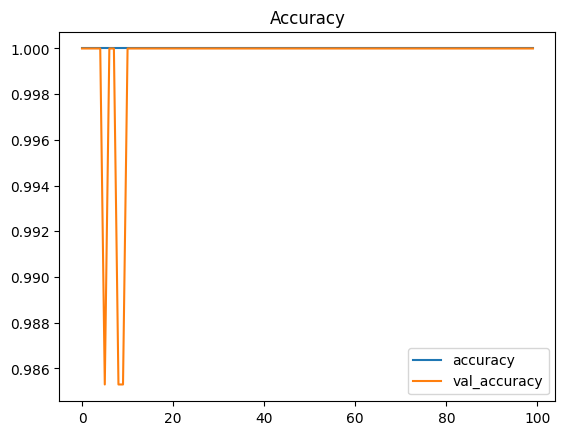

In [13]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

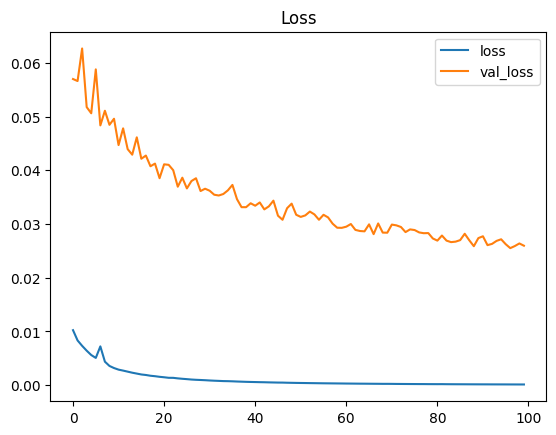

In [14]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [15]:
#Predict the label of the test_images
pred = best_model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

1/3 [=========>....................] - ETA: 0s

C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 1s 377ms/step
Accuracy on the test set: 88.31%


In [16]:
#모델의 정밀도와 재현율
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

        coca       0.81      1.00      0.90        13
       fanta       1.00      0.87      0.93        15
       pepsi       0.88      0.74      0.80        19
      pocari       0.80      0.86      0.83        14
      sprite       0.94      1.00      0.97        16

    accuracy                           0.88        77
   macro avg       0.89      0.89      0.88        77
weighted avg       0.89      0.88      0.88        77



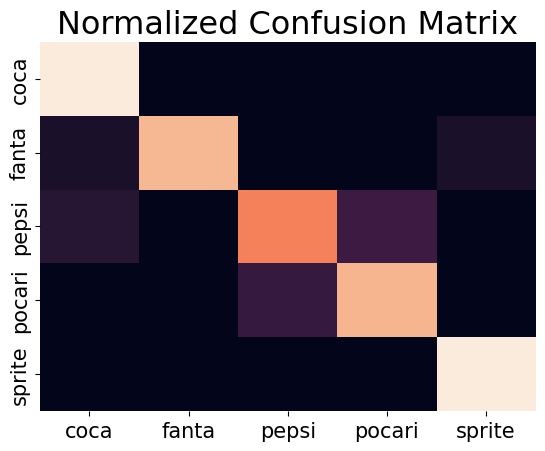

In [17]:
#Confusion Matrix 시각화
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
#실제 데이터##
# 데이터 경로
base_dir = Path(r'C:\Users\ysm\Desktop\testdata')
brands = ['coca', 'fanta', 'pepsi', 'pocari', 'sprite']  # 브랜드 목록

# 각 브랜드별 이미지 파일 경로 수집
filepaths = []
labels = []

for brand in brands:
    brand_dir = base_dir / brand  # 각 브랜드의 폴더 경로
    brand_images = list(brand_dir.glob(r'*.jpg'))  # JPG 이미지만 수집
    filepaths.extend(brand_images)
    labels.extend([brand] * len(brand_images))  # 브랜드 이름으로 라벨 지정

# 데이터프레임 생성
df = pd.DataFrame({
    'Filepath': [str(fp) for fp in filepaths],
    'Label': labels
})

# 음료수 별 이미지 수 최소값 찾기 
min_count = df['Label'].value_counts().min()

# 그 수를 기준으로 샘플링
can_df = pd.concat([
    df[df['Label'] == brand].sample(min_count, random_state=0)
    for brand in brands
])
can_df = can_df.sample(frac=1, random_state=0).reset_index(drop=True)

# 라벨링 확인
print(can_df)

1/1 [==============================] - 0s 128ms/step


## 예측률 : 100.00%

### Class prediction = coca

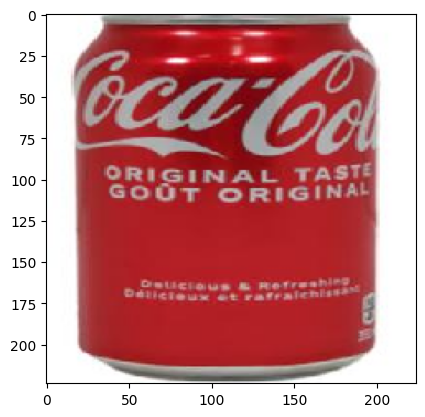

In [18]:
# 모델 예측
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
class_dictionary = {'coca': 0,
                    'fanta': 1,
                    'pepsi': 2,
                    'pocari': 3,
                    'sprite': 4}
IMAGE_SIZE    = (224, 224)

#테스트할 이미지
image_path = r"C:\Users\ysm\Desktop\dataset\coca\coca173.jpg"
test_image = image.load_img(image_path, target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = best_model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

In [31]:
##실제 데이터 테스트##

#데이터 경로
base_dir = Path(r'C:\Users\ysm\Desktop\testdata')
brands = ['coca', 'fanta', 'pepsi', 'pocari', 'sprite']  # 브랜드 목록

# 각 브랜드별 이미지 파일 경로 수집
filepaths = []
labels = []

for brand in brands:
    brand_dir = base_dir / brand  # 각 브랜드의 폴더 경로
    brand_images = list(brand_dir.glob(r'*.jpg'))  # JPG 이미지만 수집
    filepaths.extend(brand_images)
    labels.extend([brand] * len(brand_images))  # 브랜드 이름으로 라벨 지정

# 데이터프레임 생성
df = pd.DataFrame({
    'Filepath': [str(fp) for fp in filepaths],
    'Label': labels
})

# 음료수 별 이미지 수 최소값 찾기 
min_count = df['Label'].value_counts().min()

# 그 수를 기준으로 샘플링
can_df = pd.concat([
    df[df['Label'] == brand].sample(min_count, random_state=0)
    for brand in brands
])
can_df = can_df.sample(frac=1, random_state=0).reset_index(drop=True)

# 라벨링 확인
print(can_df)

                                            Filepath   Label
0  C:\Users\ysm\Desktop\testdata\fanta\test2.fant...   fanta
1  C:\Users\ysm\Desktop\testdata\sprite\test2.spr...  sprite
2  C:\Users\ysm\Desktop\testdata\pepsi\test2.peps...   pepsi
3  C:\Users\ysm\Desktop\testdata\sprite\test1.spr...  sprite
4  C:\Users\ysm\Desktop\testdata\coca\test1.coca.jpg    coca
5  C:\Users\ysm\Desktop\testdata\pocari\test2.poc...  pocari
6  C:\Users\ysm\Desktop\testdata\pocari\tes1.poca...  pocari
7  C:\Users\ysm\Desktop\testdata\fanta\test1.fant...   fanta
8  C:\Users\ysm\Desktop\testdata\coca\test2.coca.jpg    coca
9  C:\Users\ysm\Desktop\testdata\pepsi\test1.peps...   pepsi


1/1 [==============================] - 0s 40ms/step


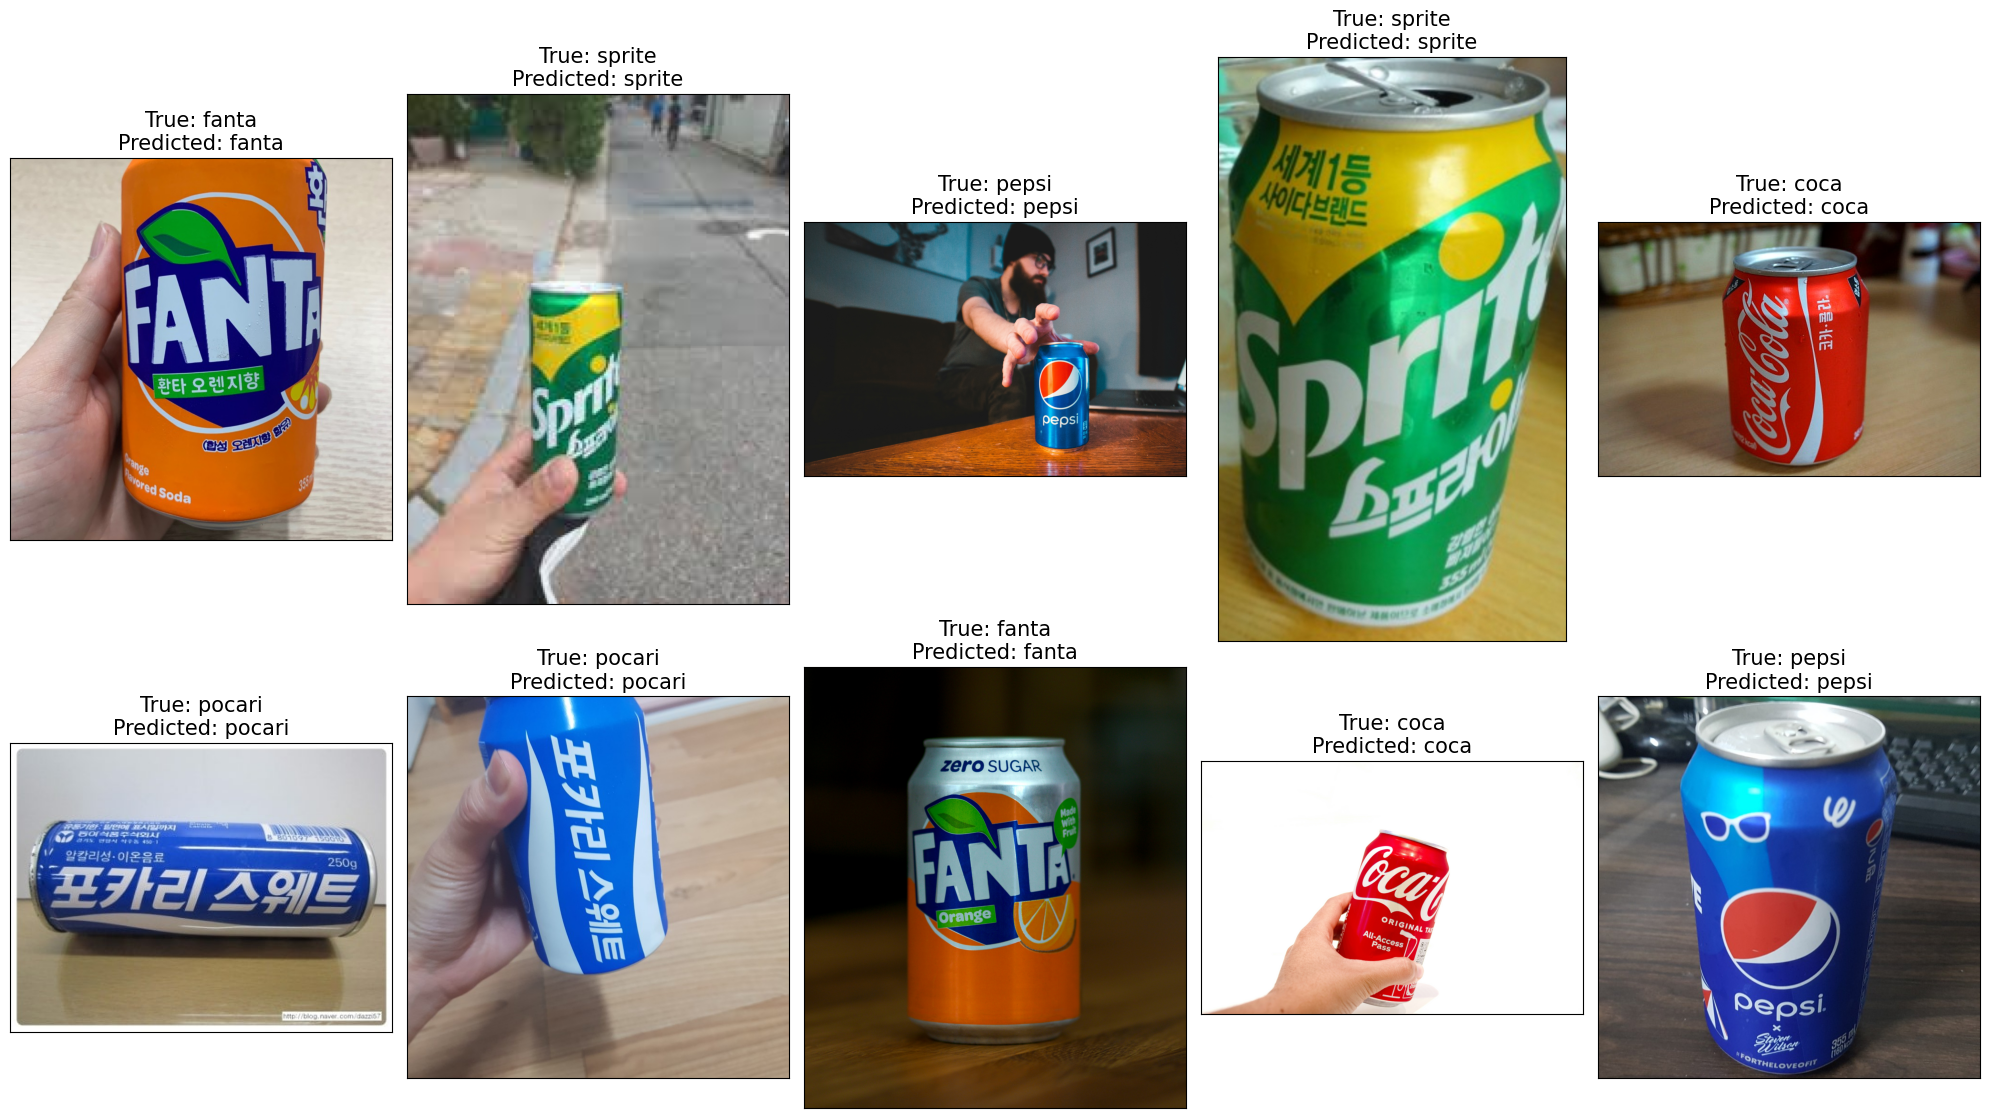

In [34]:
# 여러 이미지 예측 및 시각화
IMAGE_SIZE = (224, 224)
predictions = []

# 이미지 전처리 및 예측
for filepath in can_df['Filepath']:
    img = image.load_img(filepath, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
    img_array = preprocess_input(img_array)
    
    pred = best_model.predict(img_array)
    pred_class = np.argmax(pred, axis=1)
    
    predictions.append(pred_class[0])

# 클래스 인덱스 매핑
class_labels = {v: k for k, v in class_dictionary.items()}
can_df['Predicted'] = [class_labels[pred] for pred in predictions]

# 시각화
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(can_df):
        img = plt.imread(can_df.Filepath.iloc[i])
        ax.imshow(img)
        true_label = can_df.Label.iloc[i]
        predicted_label = can_df.Predicted.iloc[i]
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", fontsize=15)
plt.tight_layout()
plt.show()